# Timing benchmarks for various GraphSAT procedures

## Procedure 0: Bruteforce

We will be applying the bruteforce satchecker to all 3, 4, 5 vertex graphs.

- First, we create `multi=False` graphs using the following parameter.
- Parameters: `v=5`, `emin=3`, `emax= 5-choose-3 = 10`, `mixed=True`, `multi=False`.
- These parameters are set in the makefile and result in the following make command --
    `./make.py all 5 3 10 Mixed Uni`
- We now have 3845 suspects.

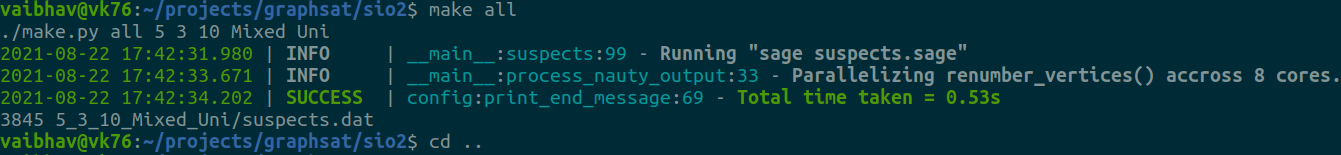

In [1]:
import itertools as it
import random
from typing import Iterator, Literal, Optional, Union

from loguru import logger
import more_itertools as mit
from tqdm import tqdm  # type: ignore

import graphsat.cnf as cnf
import graphsat.mhgraph as mhg
import graphsat.graph_rewrite as grw
import graphsat.operations as op
from graphsat import sat
import sio2.dat_management as datm

In [4]:
# This line reads the data file and allows us to iterate through the suspects.
suspects: Iterator[mhg.MHGraph] = datm.read_dat('../sio2/5_3_10_Mixed_Uni/suspects.dat')

In [25]:
%%timeit -n 1 -r 1

TAKE_ONLY: int = 10  # or 1000000000

statuses: list[bool] = []
suspects: Iterator[mhg.MHGraph] = datm.read_dat('../sio2/5_3_10_Mixed_Uni/suspects.dat')

for g in tqdm(mit.take(TAKE_ONLY, suspects)):
    if not (status := sat.mhgraph_bruteforce_satcheck(g)):
        statuses.append(status)
print(statuses)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10/10 [00:22<00:00,  2.25s/it]

[]
22.5 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


#### Note: We stopped the above timing test at 10 suspects.
because it was taking too long. It will take roughly in the order of 2+ seconds per graph, which is

In [5]:
f'{2.25 * 3845 /60/60} hours'

'2.403125 hours'

## Procedure 1: Partition at a single vertex

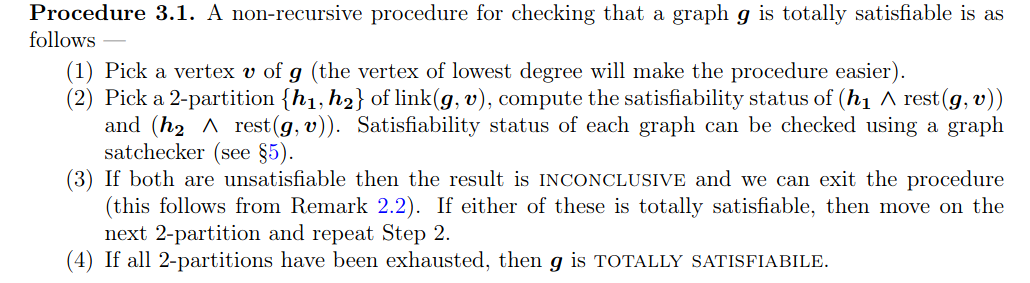

In [5]:
Status = Literal['TOTALLY SATISFIABLE', 'INCONCLUSIVE']

def procedure1(g: mhg.MHGraph) -> Status:
    """An implementation of Procedure 3.1"""
    # Pick a vertex
    v: mhg.Vertex = mhg.pick_min_degree_vertex(g)

    # Compute the rest
    rest: mhg.MHGraph = mhg.mhgraph(mhg.sphr(g, v))
    
    # Compute partitions of the link
    h1_h2_iter: Iterator[tuple[list[mhg.HEdge], list[mhg.HEdge]]]
    h1_h2_iter = grw.compute_all_two_partitions_of_link(g, v)
    
    #  Loop and satcheck
    for h1, h2 in h1_h2_iter:
        h1_and_rest: mhg.MHGraph = op.graph_and(mhg.mhgraph(h1), rest)
        h2_and_rest: mhg.MHGraph = op.graph_and(mhg.mhgraph(h2), rest)
        
        mbs = sat.mhgraph_bruteforce_satcheck  # an alias
        if not mbs(h1_and_rest) and not mbs(h2_and_rest):
            return 'INCONCLUSIVE'
    return 'TOTALLY SATISFIABLE'

In [16]:
%%timeit -n 1 -r 1

TAKE_ONLY: int = 100  # or 1000000000
statuses: List[Status] = []
suspects: Iterator[mhg.MHGraph] = datm.read_dat('../sio2/5_3_10_Mixed_Uni/suspects.dat')
 
for g in tqdm(mit.take(TAKE_ONLY, suspects)):
    status: Status = procedure1(g)
    statuses.append(status)
        
print(statuses)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  7.58it/s]

['TOTALLY SATISFIABLE']
136 ms ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)


## Procedure 2: Recursion but no loop

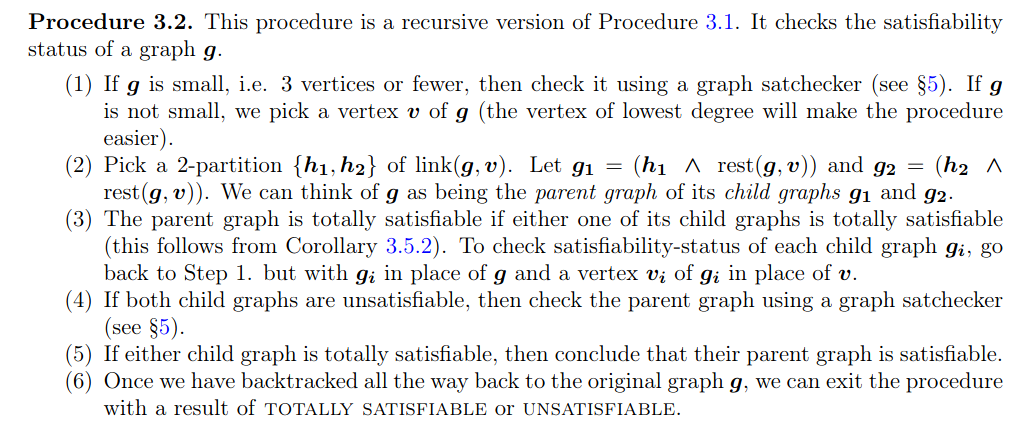

In [8]:
Status = Literal['TOTALLY SATISFIABLE', 'UNSATISFIABLE']

def direct_satcheck(g: mhg.MHGraph) -> Status:
    """Bruteforce satchecking of graph."""
    if sat.mhgraph_bruteforce_satcheck(g):
        return 'TOTALLY SATISFIABLE'
    return 'UNSATISFIABLE'

def procedure2(g: mhg.MHGraph) -> Optional[Status]:
    """Implements single pass of Procedure 2."""
    # Small graphs are directly satchecked.
    if isinstance(g, mhg.MHGraph) and len(mhg.vertices(g)) <= 3:
        return direct_satcheck(g)
    
    # Graphs are simplified at loops and leaves
    g_simp: bool | mhg.MHGraph = sat.simplify_at_leaves_and_loops(g)
    if isinstance(g_simp, bool):
        return 'TOTALLY SATISFIABLE' if g_simp else None
    if g_simp != g:
        return procedure2(g_simp)
    
    # Pick a vertex
    v: mhg.Vertex = mhg.pick_min_degree_vertex(g)
    
    # Compute the rest and the link
    rest: mhg.MHGraph = mhg.mhgraph(mhg.sphr(g, v))
    link: mhg.MHGraph = mhg.mhgraph(mhg.link(g, v))

    # Compute partitions of the link
    # Guaranteed to be a non-empty iterator.
    h1_h2_iter: Iterator[tuple[list[mhg.HEdge], list[mhg.HEdge]]]
    h1_h2_iter = grw.compute_all_two_partitions_of_link(g, v)
    
    # Compute a random index
    number_of_edges: int = len(link)
    assert number_of_edges
    max_index: int = 2**(number_of_edges-1) - 1
    random_index: int = random.randint(0, max_index-1)
    
    # Pick random 2-partition of link
    h1, h2 = mit.nth(h1_h2_iter, random_index)
    
    g1: mhg.MHGraph = op.graph_and(mhg.mhgraph(h1), rest)
    g2: mhg.MHGraph = op.graph_and(mhg.mhgraph(h2), rest)
    
    sat1: Status
    sat2: Status
    if (sat1 := procedure2(g1) == 'TOTALLY SATISFIABLE') or (sat2 := procedure2(g2) == 'TOTALLY SATISFIABLE'):
        return 'TOTALLY SATISFIABLE'
    return

In [10]:
#%%timeit -n 1 -r 1

import sys
logger.add(sys.stderr, level='DEBUG')

TAKE_ONLY: int = 100  # or 1000000000
statuses: list[Status] = []
suspects: Iterator[mhg.MHGraph] = datm.read_dat('../sio2/5_3_10_Mixed_Uni/suspects.dat')    

for g in tqdm(mit.take(TAKE_ONLY, suspects)):
    status = procedure2(g) or procedure1(g)
    statuses.append(status)
            
print(statuses)

  0%|                                                                                                                                                | 0/100 [00:00<?, ?it/s]2021-08-26 09:24:09.673 | SUCCESS  | graphsat.sat:simplify_at_loops:532 - (1)¹,(1, 2)¹,(1, 4, 5)¹,(2, 4, 5)¹ simplified to (2)¹,(4, 5)¹,(2, 4, 5)¹
2021-08-26 09:24:09.673 | SUCCESS  | graphsat.sat:simplify_at_loops:532 - (1)¹,(1, 2)¹,(1, 4, 5)¹,(2, 4, 5)¹ simplified to (2)¹,(4, 5)¹,(2, 4, 5)¹
2021-08-26 09:24:09.686 | SUCCESS  | graphsat.sat:simplify_at_loops:532 - (2)¹,(2, 4)¹,(2, 3, 5)¹,(3, 4, 5)¹ simplified to (4)¹,(3, 5)¹,(3, 4, 5)¹
2021-08-26 09:24:09.686 | SUCCESS  | graphsat.sat:simplify_at_loops:532 - (2)¹,(2, 4)¹,(2, 3, 5)¹,(3, 4, 5)¹ simplified to (4)¹,(3, 5)¹,(3, 4, 5)¹
2021-08-26 09:24:09.689 | SUCCESS  | graphsat.sat:simplify_at_loops:532 - (4)¹,(3, 5)¹,(3, 4, 5)¹ simplified to (3, 5)²
2021-08-26 09:24:09.689 | SUCCESS  | graphsat.sat:simplify_at_loops:532 - (4)¹,(3, 5)¹,(3, 4, 5)¹ simplified to (3, 5)²

ValueError: empty range for randrange() (0, 0, 0)

In [15]:
261000/1900000*100

13.736842105263158

In [3]:
op.graph_and??

Signature:
op.graph_and(
    graph1: Union[graphsat.mhgraph.MHGraph, set],
    graph2: Union[graphsat.mhgraph.MHGraph, set],
) -> set
Docstring: Conjunct the corresponding Cnfs.
File:      ~/projects/graphsat/graphsat/operations.py
Type:      function
